In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
cohort = pd.read_table('AML_cohort.txt')
from collections import OrderedDict

In [370]:
import scanpy as sc

all_tcr=pd.read_csv('AML_DLI_TRB.csv',index_col = 0)
# tcr = all_tcr[all_tcr['cdr3'].notnull()]


In [362]:
adata = sc.AnnData(all_tcr)

/home/cyp2111_columbia_edu/anaconda3/lib/python3.8/site-packages/anndata/utils.py:252: UserWarning: X converted to numpy array with dtype object
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


In [412]:
data_df

NameError: name 'data_df' is not defined

In [368]:
# adata = adata[ (~adata.obs['T-subtype'].str.contains('NK_')) & (~adata.obs['Log10CloneSize'].isna()) & (adata.obs.y>-2.8) & (adata.obs.y<9.8) ].copy()


In [240]:
# tcr.to_csv('tcr_jan24.csv')

In [239]:
all_tcr[all_tcr['Log10CloneSize']>0]

,barcode,x,y,cluster_number,patient,response,sample,time,cdr3,T-subtype,batch,Log10CloneSize
1,AAACCTGAGTCCTCCT-1-0,-2.495751,-0.160841,0,LB,RESPONDER,LB1,POST,CASSLTLPSYEQYF,TEMRA,0,1.505150
8,AAACCTGGTCTCTCGT-1-0,-3.260597,0.094545,0,LB,RESPONDER,LB1,POST,CASSPLTGELFF,TEMRA,0,0.477121
10,AAACCTGGTGATGTCT-1-0,-1.986154,-0.465736,0,LB,RESPONDER,LB1,POST,CASSLRTGVNEQFF,TEMRA,0,2.158362
11,AAACCTGGTTCTGAAC-1-0,-1.690062,-0.004227,0,LB,RESPONDER,LB1,POST,CASSPGTSWNEQFF,TEMRA,0,1.544068
15,AAACCTGTCCGTTGTC-1-0,-2.154290,0.736180,0,LB,RESPONDER,LB1,POST,CASSIAGSYEQYF,TEMRA,0,1.041393
...,...,...,...,...,...,...,...,...,...,...,...,...
45387,TTTGGTTTCTTCAACT-1-13,-0.210939,2.968548,18,AH,NONRESPONDER,AH,DLI,CASSEEGGRQPQHF,TCM,13,0.778151
45389,TTTGTCAAGCTGGAAC-1-13,0.142730,4.645897,18,AH,NONRESPONDER,AH,DLI,CASSSASGNTIYF,TCM,13,0.602060
45391,TTTGTCAAGGCCGAAT-1-13,0.193815,4.595751,18,AH,NONRESPONDER,AH,DLI,CASSLGGGARISYEQYF,TCM,13,2.008600
45395,TTTGTCACAGACAAAT-1-13,-3.501725,0.133351,0,AH,NONRESPONDER,AH,DLI,CASSQTSGSVNEQFF,TEMRA,13,1.230449


In [374]:
# tcr = pd.read_csv('TCR_total_2p_new.csv', index_col = 0)

time_dict = OrderedDict()
for sample in np.unique(tcr['sample']):
    df = tcr[tcr['sample']==sample]
    a,c = np.unique(df['time'],return_counts = True)
#     print(a,c)x
    time_dict[sample] = a[0]

In [375]:
time_dict['LB3'] = 'PRE'

In [376]:

clone_df = pd.DataFrame(index = np.unique(tcr['cdr3']), columns = ['num_unique_patients','Log10CloneSize','PRE','POST','DLI'])
for clone in np.unique(tcr['cdr3']):
    df = tcr[tcr['cdr3']==clone]
    clone_df.loc[clone,'num_unique_patients'] = len(np.unique(df['patient']))
    clone_df.loc[clone,'Log10CloneSize'] = df['Log10CloneSize'][0]
    
    a,c = np.unique(df['time'],return_counts = True)
    
    for i, time in enumerate(a):
        clone_df.loc[clone,time] = c[i]
        

    
clone_df = clone_df.fillna(0)




### relabel incorrect tcrs and remove ambiguous ones
dup = clone_df[clone_df['num_unique_patients']>1]
dup_df = pd.DataFrame(index = dup.index, columns = np.unique(tcr['patient']))
dup_df['majority_ratio'] = 0
dup_df = dup_df.fillna(0)
for clone in dup.index:
    df = tcr[tcr['cdr3']==clone]
    a,c = np.unique(df['patient'],return_counts = True)

    total = len(df)
#     dup_df.loc[clone] = np.zeros(len(patients)+1)
    max_r = 0

    for i,p in enumerate(a):
        
        dup_df.loc[clone, p] = c[i]
        
        ratio = c[i]/total

        if ratio > max_r:
            dup_df.loc[clone,'majority_ratio'] = ratio
            max_r = ratio

        
    

dup_df['total'] = dup_df.sum(axis = 1) - dup_df['majority_ratio']


remove = list(dup_df.index[dup_df['majority_ratio']<0.8])
tcr = tcr[~tcr['cdr3'].isin(remove)]

reassign = list(dup_df.index[dup_df['majority_ratio']>0.8])

k1 = ['LB1_', 'EL1_','GD1_','JS1_']
k2 = ['LB2_','EL2_','GD2_','AH1_']
k3 = ['AM1_','LB3_','EL3_','KC1_']
k4 = ['AM2_','LB4_','EL4_','MS1_']
k5 = ['AH2_','KC2_','MS2_','LB5_']
k6 = ['KC3_','MS3_','LB6_','JS2_']
k7 = ['AH3_','KC4_','MS4_','GD3_']

# len(reassign)
for clone in reassign:
    df = tcr[tcr['cdr3']==clone]
    a,c = np.unique(df['patient'],return_counts = True)
    main_patient = a[c==max(c)][0]
    
    others = np.array(a[c!=max(c)])
    df_wrong = df[df['patient'].isin(others)]
    for index in df_wrong.index: 
        sample = df_wrong.loc[index, 'sample']
        sample = sample + '_'
        for k in [k1,k2,k3,k4,k5,k6,k7]:
            if sample in k:
                for sub_k in k: 
                    if main_patient in sub_k: 
                        new_samp = sub_k[:-1]
        main_time = time_dict[new_samp]           
        print(sample, new_samp, main_time)
        tcr.loc[index,'sample'] = new_samp
        tcr.loc[index,'patient'] = main_patient
        tcr.loc[index,'time'] = main_time
        
        

        
clone_df = pd.DataFrame(index = np.unique(tcr['cdr3']), columns = ['num_unique_patients','Log10CloneSize','PRE','POST','DLI'])
for clone in np.unique(tcr['cdr3']):
    df = tcr[tcr['cdr3']==clone]
    clone_df.loc[clone,'num_unique_patients'] = len(np.unique(df['patient']))
    clone_df.loc[clone,'Log10CloneSize'] = df['Log10CloneSize'][0]
    
    a,c = np.unique(df['time'],return_counts = True)
    
    for i, time in enumerate(a):
        clone_df.loc[clone,time] = c[i]
        

    
clone_df = clone_df.fillna(0)

In [377]:
patients = [ 'EL', 'KC', 'LB', 'MS','AH', 'AM', 'GD', 'JS']
r = [ 'EL', 'KC', 'LB', 'MS']
nr = ['AH', 'AM', 'GD', 'JS']

In [251]:
patient_df = pd.DataFrame(index = patients, columns = np.unique(tcr['time']))

for patient in patients: 
    
    df = tcr[tcr['patient']==patient]
    a,c = np.unique(df['time'], return_counts = True)
    
    for i,t in enumerate(a):
        patient_df.loc[patient, t] = c[i]
        

        
        
sample_arr = np.unique(tcr['sample'])
sample_df = pd.DataFrame(index = sample_arr, columns = np.unique(tcr['time']))

for sample in sample_arr: 
    sample = sample
    df = tcr[tcr['sample']==sample]
    a,c = np.unique(df['time'], return_counts = True)
    
    for i,t in enumerate(a):
        sample_df.loc[sample, t] = c[i]
        
sample_df = sample_df.fillna(0)

patient_df = patient_df.fillna(0)

In [252]:
np.sum(patient_df.values)

27144

In [253]:
patient_df.sum(axis = 1)

EL    2736
KC    5221
LB    5734
MS    4070
AH    5783
AM    1504
GD     422
JS    1674
dtype: int64

In [245]:
np.unique(clone_df['num_unique_patients'],return_counts = True)

(array([1]), array([1049]))

In [23]:
np.unique(clone_df['num_unique_patients'],return_counts = True)

(array([1, 2, 3, 4]), array([1031,  112,    5,    1]))

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(clone_df['Log10CloneSize'], bins = 50)
plt.show()

In [1]:
# !pip install plotly
# !pip install -U kaleido

Requirement already up-to-date: kaleido in ./anaconda3/lib/python3.8/site-packages (0.2.1)


In [247]:
# import plotly.graph_objects as go
# import urllib, json

# url = 'https://raw.githubusercontent.com/plotly/plotly.js/master/test/image/mocks/sankey_energy.json'
# response = urllib.request.urlopen(url)
# data = json.loads(response.read())

# # override gray link colors with 'source' colors
# opacity = 0.4
# # change 'magenta' to its 'rgba' value to add opacity
# data['data'][0]['node']['color'] = ['rgba(255,0,255, 0.8)' if color == "magenta" else color for color in data['data'][0]['node']['color']]
# data['data'][0]['link']['color'] = [data['data'][0]['node']['color'][src].replace("0.8", str(opacity))
#                                     for src in data['data'][0]['link']['source']]

# fig = go.Figure(data=[go.Sankey(
#     valueformat = ".0f",
#     valuesuffix = "TWh",
#     # Define nodes
#     node = dict(
#       pad = 15,
#       thickness = 15,
#       line = dict(color = "black", width = 0.5),
#       label =  data['data'][0]['node']['label'],
#       color =  data['data'][0]['node']['color']
#     ),
#     # Add links
#     link = dict(
#       source =  data['data'][0]['link']['source'],
#       target =  data['data'][0]['link']['target'],
#       value =  data['data'][0]['link']['value'],
#       label =  data['data'][0]['link']['label'],
#       color =  data['data'][0]['link']['color']
# ))])

# fig.update_layout(title_text="Energy forecast for 2050<br>Source: Department of Energy & Climate Change, Tom Counsell via <a href='https://bost.ocks.org/mike/sankey/'>Mike Bostock</a>",
#                   font_size=10)
# fig.show()

In [47]:
sub_cdr

,num_unique_patients,Log10CloneSize,PRE,POST,DLI
CAIRDEGGSPLHF,1,0.30103,0,0,2
CAISDETPNQPQHF,1,0.60206,1,2,1
CASGPGTGFYGYTF,1,0.30103,0,0,2
CASGRTSFGEQYF,1,0.30103,0,2,0
CASHRVLGRSYEQYF,1,0.30103,1,1,0
...,...,...,...,...,...
CSGGTAEPYEQYF,1,0.30103,0,0,2
CSVGVLNTGELFF,1,0.30103,0,0,2
CSVPEWNNEQFF,1,0.69897,0,5,0
CSVVDRGRFGEQYF,1,0.30103,0,0,2


In [98]:
np.unique(tcr['patient'])

array(['AH', 'AM', 'EL', 'GD', 'JS', 'KC', 'LB', 'MS'], dtype=object)

In [25]:
patients = [ 'EL', 'KC', 'LB', 'MS','AH', 'AM', 'GD', 'JS']
r = [ 'EL', 'KC', 'LB', 'MS']
nr = ['AH', 'AM', 'GD', 'JS']
sub = tcr[tcr['patient'].isin(nr)]
cdr = np.unique(sub['cdr3'])
sub_cdr = clone_df.loc[cdr]

In [26]:

# sub_cdr = sub_cdr[sub_cdr['Log10CloneSize ']>0.7]

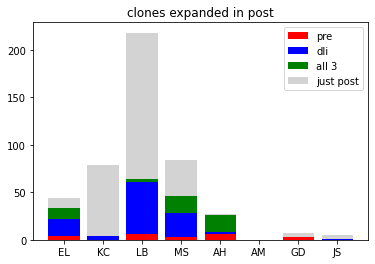

In [38]:


y_pre = []
y_dli = []
y_all = []
y_one = []

for patient in patients:
    
    
    sub = tcr[tcr['patient']==patient]
    cdr = np.unique(sub['cdr3'])
    sub_cdr = clone_df.loc[cdr]


    sub_cdr[['PRE','POST','DLI']] = np.sign(sub_cdr[['PRE','POST','DLI']] )
#     ms = sub_cdr[['PRE','POST','DLI']].sum(axis = 1)
#     keep = ms.index[ms!=1]
#     sub_cdr = sub_cdr.loc[keep]
#     sub_cdr_no3= pd.DataFrame.copy(sub_cdr)
#     sub_cdr_no3 = sub_cdr_no3.loc[keep]


    source_arr = []
    target_arr = []
    val_arr = []

    total_clones = len(sub[sub['time']=='POST'])
    total_clones= 1
#     if total_clones == 0:
#         print(f'no clones in POST for {patient}')
#         y_pre.append(0)
#         y_dli.append(0)
#         y_all.append(0)
#         y_one.append(0)
#         continue
        
    source_arr.append(0)
    target_arr.append(2)

    df_sub = sub_cdr[sub_cdr['PRE']==1]
    df_sub = df_sub[df_sub['POST']==1]
    df_sub = df_sub[df_sub['DLI']==0]
    
    val_arr.append(len(df_sub))
    pre = len(df_sub)
    
    y_pre.append(len(df_sub)/total_clones)



    source_arr.append(1)
    target_arr.append(2)

    df_sub = sub_cdr[sub_cdr['DLI']==1]
    df_sub = df_sub[df_sub['POST']==1]
    df_sub = df_sub[df_sub['PRE']==0]
    val_arr.append(len(df_sub))
    y_dli.append(len(df_sub)/total_clones)
    dli = len(df_sub)
    
    
    df_sub = sub_cdr[sub_cdr['DLI']==1]
    df_sub = df_sub[df_sub['POST']==1]
    df_sub = df_sub[df_sub['PRE']==1]
    val_arr.append(len(df_sub))
    y_all.append(len(df_sub)/total_clones)
    
    
#     print(f'{patient}, {pre} pre clones, {dli} dli clones, {np.round(dli/len(sub_cdr)*100,2)} % dli,{np.round(pre/len(sub_cdr)*100,2)} % pre ')


    sub_cdr[['PRE','POST','DLI']] = np.sign(sub_cdr[['PRE','POST','DLI']] )
    ms = sub_cdr[['PRE','POST','DLI']].sum(axis = 1)
    keep = ms.index[ms==1]
    df_sub = sub_cdr.loc[keep]

    df_sub = sub_cdr[sub_cdr['DLI']==0]
    df_sub = df_sub[df_sub['POST']==1]
    df_sub = df_sub[df_sub['PRE']==0]
    val_arr.append(len(df_sub))
#     y_one.append(len(df_sub))
    
    y_one.append(len(df_sub)/total_clones)
    
    
    


x = patients

# plot bars in stack manner
plt.figure()
plt.bar(x, y_pre, color='r', label = 'pre')
plt.bar(x, y_dli, bottom=y_pre, color='b', label = 'dli')
plt.bar(x, y_all, bottom=np.array(y_pre)+np.array(y_dli), color='g', label = 'all 3')
plt.bar(x, y_one, bottom=np.array(y_pre)+np.array(y_dli)+np.array(y_all), color='lightgrey', label = 'just post')
plt.legend()
plt.title('clones expanded in post')
# plt.savefig('tcr_no_grey.eps')
plt.show()



In [149]:
r_df=  tcr[tcr['patient'].isin(nr)]
r_df

,sample,time,response,cluster_number,cdr3,patient,T-subtype,batch,Log10CloneSize,VDJdb
barcode,,,,,,,,,,
AAACGGGTCTAACGGT-1-0,JS1,PRE,NONRESPONDER,5,CASSLLDRGDTEAFF,JS,TEM/TRM_1,0,0.301030,0
AACGTTGAGCGTCTAT-1-0,GD1,PRE,NONRESPONDER,2,CAISDRDGSSYEQYF,GD,Naive_Helper_1,0,0.301030,0
AACTCCCAGAACAACT-1-0,GD1,PRE,NONRESPONDER,28,CASSPQGLAGSSGANVLTF,GD,MAIT,0,0.301030,0
AATCCAGGTCGCGTGT-1-0,JS1,PRE,NONRESPONDER,40,CASSLAPQGATGELFF,JS,TEM/TRM_3,0,0.602060,0
ACAGCCGAGACCTAGG-1-0,GD1,PRE,NONRESPONDER,2,CSGDRPGINEKLFF,GD,Naive_Helper_1,0,1.041393,0
...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCTTCAACT-1-13,AH,DLI,NONRESPONDER,18,CASSEEGGRQPQHF,AH,TCM,13,0.778151,0
TTTGTCAAGCTGGAAC-1-13,AH,DLI,NONRESPONDER,18,CASSSASGNTIYF,AH,TCM,13,0.602060,0
TTTGTCAAGGCCGAAT-1-13,AH,DLI,NONRESPONDER,18,CASSLGGGARISYEQYF,AH,TCM,13,2.008600,0


In [150]:
clone_r = clone_df.loc[np.unique(r_df['cdr3'])]
clone_r

,num_unique_patients,Log10CloneSize,PRE,POST,DLI
CAAVESWDRNTEAFF,1,0.698970,2,0,3
CACGQAYGYTF,1,0.778151,1,0,5
CAGGGAEGRAGELFF,1,0.301030,2,0,0
CAGNRDSTFSGANVLTF,1,0.301030,1,0,1
CAISDRDGSSYEQYF,1,0.301030,2,0,0
...,...,...,...,...,...
CSVAADRAYGYTF,1,1.230449,10,0,7
CSVEVLMGGRYTEAFF,1,0.477121,1,1,1
CSVEVPMGTSGPGSYEQYF,1,0.602060,0,0,4
CSVGTGPGNTIYF,1,0.301030,0,0,2


In [156]:
np.log10(3)

0.47712125471966244

In [157]:
large = clone_df[clone_df['Log10CloneSize']>np.log10(3)]
large

,num_unique_patients,Log10CloneSize,PRE,POST,DLI
CAAVESWDRNTEAFF,1,0.698970,2,0,3
CACGQAYGYTF,1,0.778151,1,0,5
CAINIRHGRNSPLHF,1,0.602060,0,0,4
CAIRDAGGPWETQYF,1,0.954243,1,7,1
CAISDETPNQPQHF,1,0.602060,1,2,1
...,...,...,...,...,...
CSVPEWNNEQFF,1,0.698970,0,5,0
CSVQGSYEQYF,1,1.079181,0,0,12
CSVTGSGGPLDEQFF,1,1.908485,1,58,21
CSVVDQRSGANVLTF,1,0.954243,0,9,0


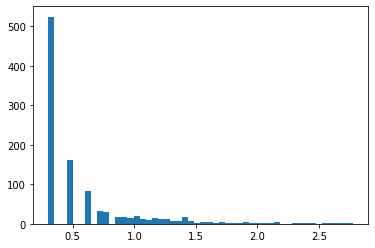

In [153]:
plt.figure()
plt.hist(clone_df['Log10CloneSize'], bins = 50)
plt.show()

In [159]:
dd= list (set(vdj.CDR3) & set(clone_r.index))
len(dd)

11

In [155]:
vdj=pd.read_table('vdjdb-2023-04-26.tsv.gz')
dd= list (set(vdj.CDR3) & set(large.index))
len(dd)

4

In [143]:
c0 = vdj_overlap[vdj_overlap['cluster_number']==0]
c0

,sample,time,response,cluster_number,cdr3,patient,T-subtype,batch,Log10CloneSize,VDJdb
barcode,,,,,,,,,,
AGCCTAAAGAAGGACA-1-0,LB1,POST,RESPONDER,0,CASSPISNEQFF,LB,TEMRA,0,1.612784,1
CATTCGCGTCACAAGG-1-0,LB1,POST,RESPONDER,0,CASSPISNEQFF,LB,TEMRA,0,1.612784,1
CCTCAGTGTTACCGAT-1-0,LB1,POST,RESPONDER,0,CASSPISNEQFF,LB,TEMRA,0,1.612784,1
CGAGCCAAGTAGCCGA-1-0,LB1,POST,RESPONDER,0,CASSPISNEQFF,LB,TEMRA,0,1.612784,1
CGCGTTTTCTAACTGG-1-0,LB1,POST,RESPONDER,0,CASSPISNEQFF,LB,TEMRA,0,1.612784,1
...,...,...,...,...,...,...,...,...,...,...
GTTACAGAGTATTGGA-1-13,AH,DLI,NONRESPONDER,0,CASSRTSGPYNEQFF,AH,TEMRA,13,2.033424,1
TATGCCCCATGTCGAT-1-13,AH,DLI,NONRESPONDER,0,CASSRTSGPYNEQFF,AH,TEMRA,13,2.033424,1
TCCACACTCCAACCAA-1-13,AH,DLI,NONRESPONDER,0,CASSRTSGPYNEQFF,AH,TEMRA,13,2.033424,1


In [125]:
subvdj=vdj[vdj.CDR3.isin(dd)][['CDR3','Epitope species']]
cdr_epi=dict(zip(subvdj['CDR3'],subvdj['Epitope species']))
tcr['VDJdb']=tcr.cdr3.isin(dd)*1

In [134]:
vdj_overlap = tcr[tcr['VDJdb']==1]
vdj_arr = np.unique(vdj_overlap['cdr3'])
len(vdj_arr)

36

In [262]:
clone_df

,num_unique_patients,Log10CloneSize,PRE,POST,DLI
CAAARVDTGELFF,1,0.0,1,0,0
CAAGALPNTGELFF,1,0.0,0,0,1
CAAGDRAYEQYF,1,0.0,0,0,1
CAAGGDDTGELFF,1,0.0,0,0,1
CAAGGTALSGANVLTF,1,0.0,0,0,1
...,...,...,...,...,...
CTGAQGVFETEAFF,1,0.0,0,1,0
CTGGAGTGELFF,1,0.0,0,0,1
CTTRVHNGYEQYF,1,0.0,1,0,0
CVASGYTELSYEQYF,1,0.0,0,0,1


In [266]:
sub = tcr[tcr['patient'].isin(r)]
cdr = np.unique(sub['cdr3'])
sub_cdr = clone_df.loc[cdr]
sub_cdr_r = clone_df.loc[cdr]
print(len(sub_cdr))


# sub_cdr = pd.DataFrame.copy(clone_df)
# sub_cdr = sub_cdr[sub_cdr['POST']>0]
sub_cdr['LCS_post'] = np.log10(sub_cdr['POST'])
sub_cdr[['PRE','POST','DLI']] = np.sign(sub_cdr[['PRE','POST','DLI']] )
sub_cdr['group'] = 'x'

COL = 'Log10CloneSize'

df_sub = sub_cdr[sub_cdr['PRE']==1]
df_sub = df_sub[df_sub['POST']==1]
df_sub = df_sub[df_sub['DLI']==0]
sub_cdr.loc[df_sub.index,'group'] = '2Pre+Post'

df_sub = sub_cdr[sub_cdr['PRE']==0]
df_sub = df_sub[df_sub['POST']==1]
df_sub = df_sub[df_sub['DLI']==1]
sub_cdr.loc[df_sub.index,'group'] = '1Dli+Post'


df_sub = sub_cdr[sub_cdr['PRE']==0]
df_sub = df_sub[df_sub['POST']==1]
df_sub = df_sub[df_sub['DLI']==0]
sub_cdr.loc[df_sub.index,'group'] = '4JustPost'

df_sub = sub_cdr[sub_cdr['PRE']==1]
df_sub = df_sub[df_sub['POST']==1]
df_sub = df_sub[df_sub['DLI']==1]
sub_cdr.loc[df_sub.index,'group'] = '3Pre+Dli+Post'

sub_cdr = sub_cdr.sort_values(by = COL)
sub_cdr = sub_cdr.sort_values(by = 'group')

range_dict = OrderedDict()
for group in np.unique(sub_cdr['group']):
    df = sub_cdr[sub_cdr['group']==group]
    range_dict[group] = [np.min(df[COL]), np.max(df[COL])]

10030


/home/cyp2111_columbia_edu/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [267]:
df = pd.DataFrame.copy(sub_cdr)

In [283]:
sub = tcr[tcr['sample']=='EL']
sub

,x,y,cluster_number,patient,response,sample,time,cdr3,T-subtype,batch,Log10CloneSize
barcode,,,,,,,,,,,
AAACCTGAGACCGGAT-1-9,-2.312204,8.371427,2,EL,RESPONDER,EL,DLI,CASSPIFGEAFF,Naive_Helper_1,9,0.00000
AAACCTGAGTAACCCT-1-9,-1.967470,7.710656,2,EL,RESPONDER,EL,DLI,CASGNSSTYEQYF,Naive_Helper_1,9,0.00000
AAACCTGAGTACGACG-1-9,-2.743206,6.342686,2,EL,RESPONDER,EL,DLI,CASSYSMNTEAFF,Naive_Helper_1,9,0.00000
AAACCTGAGTGTCCAT-1-9,-2.041350,8.206432,2,EL,RESPONDER,EL,DLI,CASSYSGGTFTYEQYF,Naive_Helper_1,9,0.00000
AAACCTGTCCGCATAA-1-9,-1.727764,7.937103,2,EL,RESPONDER,EL,DLI,CASTIRGAGNTIYF,Naive_Helper_1,9,0.00000
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTAAGTAGT-1-9,-3.038841,7.628223,2,EL,RESPONDER,EL,DLI,CASSGLAGGTGELFF,Naive_Helper_1,9,0.00000
TTTGTCAGTAGCACGA-1-9,-2.756633,8.204608,2,EL,RESPONDER,EL,DLI,CASSGTGYSETQYF,Naive_Helper_1,9,0.00000
TTTGTCAGTCCGCTGA-1-9,-3.634642,2.406767,5,EL,RESPONDER,EL,DLI,CASSWTQGPSTEAFF,TEM/TRM_1,9,0.69897


In [279]:
sample_df

,DLI,POST,PRE
AH,4666,0,0
AH1,0,0,98
AH2,0,0,948
AH3,0,71,0
AM,1390,0,0
AM1,0,0,36
AM2,0,0,78
EL,2098,0,0
EL1,0,0,169
EL2,0,304,0


In [287]:
cdr_p

,num_unique_patients,Log10CloneSize,PRE,POST,DLI,LCS_post,group
CAAARVDTGELFF,1,0.00000,1,0,0,-inf,x
CAAGGDDTGELFF,1,0.00000,0,0,1,-inf,x
CAAGPPGGEQFF,1,0.00000,0,0,1,-inf,x
CACSRGSEETQYF,1,0.00000,0,0,1,-inf,x
CACTGTLNYGYTF,1,0.00000,0,0,1,-inf,x
...,...,...,...,...,...,...,...
CSVVTRYNEQFF,1,0.00000,0,0,1,-inf,x
CSVYGEGKLSSYEQYF,1,0.30103,0,1,1,0.0,1Dli+Post
CSVYVGGGVGYTF,1,0.00000,0,1,0,0.0,4JustPost
CTTRVHNGYEQYF,1,0.00000,1,0,0,-inf,x


In [298]:
cdr_p

,num_unique_patients,Log10CloneSize,PRE,POST,DLI,LCS_post,group
CAAARVDTGELFF,1,0.00000,1,0,0,-inf,x
CAAGGDDTGELFF,1,0.00000,0,0,1,-inf,x
CAAGPPGGEQFF,1,0.00000,0,0,1,-inf,x
CACSRGSEETQYF,1,0.00000,0,0,1,-inf,x
CACTGTLNYGYTF,1,0.00000,0,0,1,-inf,x
...,...,...,...,...,...,...,...
CSVVTRYNEQFF,1,0.00000,0,0,1,-inf,x
CSVYGEGKLSSYEQYF,1,0.30103,0,1,1,0.0,1Dli+Post
CSVYVGGGVGYTF,1,0.00000,0,1,0,0.0,4JustPost
CTTRVHNGYEQYF,1,0.00000,1,0,0,-inf,x


In [300]:
import numpy as np
from scipy.stats import hypergeom
import matplotlib.pyplot as plt


for patient in r: 
    
    sub = tcr[tcr['patient']==patient]
    cdr = np.unique(sub['cdr3'])
    sub_cdr = df.loc[cdr]
    sub_cdr = sub_cdr[sub_cdr['POST']>0]
    sub_cdr = sub_cdr[sub_cdr['Log10CloneSize']>0]
    cdr_p = df.loc[cdr]
    
    # num of expanded clones overlapping post and dli
    x = len(sub_cdr[sub_cdr['group']=='1Dli+Post'])
    
    # total num of clones in post
    M = len(cdr_p[cdr_p['POST']>0])
    
    # total num of expanded clones in post
#     n_df = cdr_p[cdr_p['Log10CloneSize']>0]
#     n_df = n_df[n_df['DLI']>0]
#     n = len(n_df)
    n = len(sub_cdr[sub_cdr['Log10CloneSize']>0])

    # total num clones overlap in post&dli
    N_df = cdr_p[cdr_p['POST']>0]
    N_df = N_df[N_df['PRE']==0]
    N_df = N_df[N_df['DLI']>0]
    N = len(N_df)
#     N = len(cdr_p[cdr_p['group']=='1Dli+Post'])
  
    print(patient,x,M,n,N)
    prb_dli = hypergeom.cdf(x,M,n,N)
    print(f'DLI prob {prb_dli}')
    
    # num of expanded clones overlapping post and dli
    x = len(sub_cdr[sub_cdr['group']=='2Pre+Post'])
        # total num of clones in post
    M = len(cdr_p[cdr_p['POST']>0])
    
    # total num of expanded clones in post
#     n_df = cdr_p[cdr_p['Log10CloneSize']>0]
#     n_df = n_df[n_df['PRE']>0]
#     n = len(n_df)
    
    n = len(sub_cdr[sub_cdr['Log10CloneSize']>0])
    
    # total num clones overlap in post&dli
    
    N_df = cdr_p[cdr_p['POST']>0]
    N_df = N_df[N_df['PRE']>0]
    N_df = N_df[N_df['DLI']==0]
    N = len(N_df)
    
    
    
    
    print(patient,x,M,n,N)
    prb_pre = hypergeom.cdf(x,M,n,N)
    
    print(f'PRE prob {prb_pre}\n')
    
#     [M, n, N] = [len(sub_cdr), len(sub_cdr[sub_cdr['group']=='1Dli+Post']), len(sub_cdr[sub_cdr['group']=='2Pre+Post'])]
#     rv1 = hypergeom(M, n, N)
#     x1 = np.arange(0, n+1)
#     pmf_dli = rv1.pmf(x1)

#     scaling = len(cdr_p[cdr_p['DLI']>0])/len(cdr_p[cdr_p['PRE']>0])
#     print(patient,M,n,N)

#     [M, n, N] = [len(cdr_p), 
#                  np.round(scaling*len(cdr_p)/(scaling+1)), 
#                  np.round(len(cdr_p)/(scaling+1))]
#     print(patient,M,n,N,scaling)
#     rv2 = hypergeom(M, n, N)
#     x2 = np.arange(0, n+1)
#     pmf_null = rv2.pmf(x2)


#     fig = plt.figure(figsize = (10,5))
#     ax = fig.add_subplot(111)
#     ax.plot(x1, pmf_dli, 'bo')
#     ax.vlines(x1, 0, pmf_dli, lw=1)

#     ax.plot(x2, pmf_null,'rx')
#     ax.vlines(x2, 0, pmf_null, lw=1)
    
#     print(patient, kstest(pmf_dli,pmf_null))


#     plt.show()

EL 18 276 44 18
DLI prob 1.0
EL 4 276 44 4
PRE prob 1.0

KC 4 316 79 4
DLI prob 1.0
KC 0 316 79 0
PRE prob 1.0

LB 56 1002 218 56
DLI prob 1.0
LB 6 1002 218 6
PRE prob 1.0

MS 25 250 84 26
DLI prob 0.9999999999999756
MS 3 250 84 3
PRE prob 1.0



In [378]:
clone_df

,num_unique_patients,Log10CloneSize,PRE,POST,DLI
CAAARVDTGELFF,1,0.0,1,0,0
CAAGALPNTGELFF,1,0.0,0,0,1
CAAGDRAYEQYF,1,0.0,0,0,1
CAAGGDDTGELFF,1,0.0,0,0,1
CAAGGTALSGANVLTF,1,0.0,0,0,1
...,...,...,...,...,...
CTGAQGVFETEAFF,1,0.0,0,1,0
CTGGAGTGELFF,1,0.0,0,0,1
CTTRVHNGYEQYF,1,0.0,1,0,0
CVASGYTELSYEQYF,1,0.0,0,0,1


In [379]:
expanding_post = clone_df[clone_df['POST']>1]
expanding_post

,num_unique_patients,Log10CloneSize,PRE,POST,DLI
CAIRDAGGPWETQYF,1,0.954243,1,7,1
CAIRSAGTRAIYEQYF,1,0.301030,0,2,0
CAISDETPNQPQHF,1,0.602060,1,2,1
CAISETGGIGQPQHF,1,0.301030,0,2,0
CAITRDGPTDTQYF,1,0.301030,0,2,0
...,...,...,...,...,...
CSVTGSGGPLDEQFF,1,1.908485,1,61,21
CSVTRRETEAFF,1,0.301030,0,2,0
CSVVDQRSGANVLTF,1,0.954243,0,9,0
CSVVGTGKTYEQYF,1,0.301030,0,2,0


In [395]:
sub_clone['cdr3'] = sub_clone.index
exist_post = sub_clone[sub_clone['POST']>=1]
not_exist_post = sub_clone[sub_clone['DLI']==0]
common_rows = pd.merge(exist_post, not_exist_post, how='inner', on = 'cdr3')
common_rows

,num_unique_patients_x,Log10CloneSize_x,PRE_x,POST_x,DLI_x,cdr3,num_unique_patients_y,Log10CloneSize_y,PRE_y,POST_y,DLI_y
0,1,0.00000,0,1,0,CAISDNTYSQGTRNSQHF,1,0.00000,0,1,0
1,1,0.00000,0,1,0,CASLTPPNTGELFF,1,0.00000,0,1,0
2,1,0.00000,0,1,0,CASSAMTVNTEAFF,1,0.00000,0,1,0
3,1,0.30103,0,2,0,CASSDIGKGQQETQYF,1,0.30103,0,2,0
4,1,0.00000,0,1,0,CASSDLHNEQFF,1,0.00000,0,1,0
5,1,0.00000,0,1,0,CASSEWWWQESSYNEQFF,1,0.00000,0,1,0
6,1,0.00000,0,1,0,CASSFGGQPQHF,1,0.00000,0,1,0
7,1,0.00000,0,1,0,CASSFSTGGISYEQYF,1,0.00000,0,1,0
8,1,0.00000,0,1,0,CASSFSVEQYF,1,0.00000,0,1,0
9,1,0.00000,0,1,0,CASSGSLGADEQFF,1,0.00000,0,1,0


In [411]:
from scipy.stats import fisher_exact 



# Class I - expanding in post
# II - non expanding in post 
# in DLI 
# not in DLI


# Blue - POST+DLI also expanding in DLI
# Red- DLI not in post and post not in DLI 
# Expanding = more than one at same time point

p_dli = OrderedDict()
for patient in patients: 
    sub = tcr[tcr['patient']==patient]
    cdr = np.unique(sub['cdr3'])
    sub_clone = clone_df.loc[cdr]
    sub_clone['cdr3'] = sub_clone.index
    
    exist_post = sub_clone[sub_clone['POST']>=1]
    not_exist_post = sub_clone[sub_clone['POST']==0]
    
    exist_dli = sub_clone[sub_clone['DLI']>=1]
    exist_pre = sub_clone[sub_clone['PRE']>=1]
    
    a = len(pd.merge(exist_post,exist_pre, how='inner', on = 'cdr3'))
    b = len(pd.merge(not_exist_post,exist_pre, how='inner', on = 'cdr3'))
    c = len(pd.merge(exist_post,exist_dli, how='inner', on = 'cdr3'))
    d = len(pd.merge(not_exist_post,exist_dli, how='inner', on = 'cdr3'))
    

    table = np.array([[a,b], [c,d]])
    stat,pval = fisher_exact(table)
    p_dli[patient] = pval
    print(patient, stat, pval)
    print(a,b,c,d)


EL 4.3925608011444925 1.9644271026610602e-05
16 233 30 1919
KC 0.0 1.0
0 37 4 2783
LB inf 4.606447461434283e-10
9 0 59 633
MS 9.202414772727273 9.459040434138079e-12
21 128 44 2468
AH 11.1342175066313 2.3069709236068287e-13
24 377 20 3498
AM nan 1.0
0 110 0 1341
GD nan 1.0
3 268 0 0
JS 0.0 1.0
0 27 1 1398


In [392]:
p_pre = OrderedDict()
for patient in patients: 
    sub = tcr[tcr['patient']==patient]
    cdr = np.unique(sub['cdr3'])
    sub_clone = clone_df.loc[cdr]
    
    expanding_post = sub_clone[sub_clone['POST']>1]
    not_expanding_post = sub_clone[sub_clone['POST']<=1]

    # a - expanding in post and in DLI
    expanding_post_dli = expanding_post[expanding_post['PRE']>0]
    a = len(expanding_post_dli)
    # b = not expanding in post and in DLI
    not_expanding_post_dli = not_expanding_post[not_expanding_post['PRE']>0]
    b = len(not_expanding_post_dli)

    #c - expanding in post but not in DLI
    expanding_post_no_dli =expanding_post[expanding_post['PRE']==0]
    c = len(expanding_post_no_dli)

    #d - not expanding in post and not in DLI
    no_expanding_post_no_dli = not_expanding_post[not_expanding_post['PRE']==0]
    d = len(no_expanding_post_no_dli)

    table = np.array([[b,a], [d,c]])
    stat,pval = fisher_exact(table)
    p_pre[patient] = pval
    print(patient, stat, pval)


EL 0.1977139326536917 0.0005152890738525941
KC inf 1.0
LB 0.0 3.2595607730839843e-09
MS 0.15440200909780136 1.0596255133925543e-07
AH 0.012643122077084342 1.216527831819625e-08
AM nan 1.0
GD inf 0.006505548811454599
JS inf 1.0


In [390]:
for patient in patients:
    p1 = p_dli[patient]
    p2 = p_pre[patient]
    print(patient, p1-p2)

EL 0.0006666804010642263
KC -1.0
LB -3.2595607643084243e-09
MS -1.0596255133925543e-07
AH 0.20836997321555314
AM 0.0
GD 0.9934944511885454
JS -0.9999972321925933


In [409]:
expanding_post = clone_df[clone_df['POST']>1]

test = tcr[tcr['cdr3'].isin(expanding_post.index)]
np.unique(test['patient'], return_counts = True)

(array(['AH', 'EL', 'GD', 'JS', 'KC', 'LB', 'MS'], dtype=object),
 array([ 994,  212,    9,    8, 1891, 4184,  611]))

In [408]:
ex = expanding_post[expanding_post['PRE']+expanding_post['DLI']==0]
test = tcr[tcr['cdr3'].isin(ex.index)]
np.unique(test['patient'], return_counts = True)

(array(['AH', 'EL', 'GD', 'JS', 'KC', 'LB', 'MS'], dtype=object),
 array([   2,   39,    9,    8, 1888, 2838,  119]))

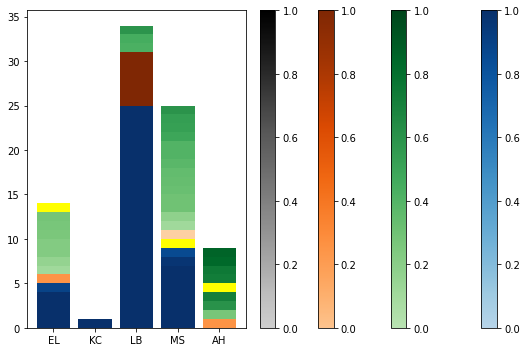

In [398]:
counter = 0
fig = plt.figure(figsize = (8,5))


for p,patient in enumerate(patients):
#     print(p)

    sub = tcr[tcr['patient']==patient]
    cdr = np.unique(sub['cdr3'])
    sub_cdr = clone_df.loc[cdr]
    sub_cdr = sub_cdr[sub_cdr['POST']>1]
    sub_cdr['LCS_post'] = np.log10(sub_cdr['POST'])
    sub_cdr[['PRE','POST','DLI']] = np.sign(sub_cdr[['PRE','POST','DLI']] )
    sub_cdr['group'] = 'x'

    df_sub = sub_cdr[sub_cdr['PRE']==1]
    df_sub = df_sub[df_sub['POST']==1]
    df_sub = df_sub[df_sub['DLI']==0]
    sub_cdr.loc[df_sub.index,'group'] = '2Pre+Post'

    df_sub = sub_cdr[sub_cdr['PRE']==0]
    df_sub = df_sub[df_sub['POST']==1]
    df_sub = df_sub[df_sub['DLI']==1]
    sub_cdr.loc[df_sub.index,'group'] = '1Dli+Post'


    df_sub = sub_cdr[sub_cdr['PRE']==0]
    df_sub = df_sub[df_sub['POST']==1]
    df_sub = df_sub[df_sub['DLI']==0]
    sub_cdr.loc[df_sub.index,'group'] = '4JustPost'

    df_sub = sub_cdr[sub_cdr['PRE']==1]
    df_sub = df_sub[df_sub['POST']==1]
    df_sub = df_sub[df_sub['DLI']==1]
    sub_cdr.loc[df_sub.index,'group'] = '3Pre+Dli+Post'

    sub_cdr = sub_cdr.sort_values(by = COL)
    sub_cdr = sub_cdr.sort_values(by = 'group')


    import matplotlib

    x = patient
    bottom_ = 0
    for group in np.unique(sub_cdr['group']):
#         print(group)
        df = sub_cdr[sub_cdr['group']==group]
        df = df.sort_values(by = COL)
        norm = plt.Normalize()
        
        min_patient = np.min(df[COL])
        max_patient = np.max(df[COL])
        min_ref, max_ref = range_dict[group]
        if min_ref == 0: min_ref = 0.1
        min_val,  max_val =0.3*(min_patient/min_ref),max_patient/max_ref
#         print(patient, min_patient, max_patient
        if group == '1Dli+Post':
            n = 20
            orig_cmap = plt.cm.Blues
            colors = orig_cmap(np.linspace(min_val, max_val, n))
            cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)
            colors = cmap1(norm(df[COL]))
        elif group == '3Pre+Dli+Post':
#             min_val, max_val = 0.3,1.0
            n = 20
            orig_cmap = plt.cm.Greens
            colors = orig_cmap(np.linspace(min_val, max_val, n))
            cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)
            colors = cmap2(norm(df[COL]))
        elif group == '2Pre+Post':
#             min_val, max_val = 0.3,1.0
            n = 20
#             print(p)
            orig_cmap = plt.cm.Oranges
            colors = orig_cmap(np.linspace(min_val, max_val, n))
            cmap3 = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)
            colors = cmap3(norm(df[COL]))
            
        elif group == '4JustPost':
            continue
#             min_val, max_val = 0.3,1.0
            n = 20
            orig_cmap = plt.cm.Greys
            colors = orig_cmap(np.linspace(min_val, max_val, n))
            cmap4 = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)
            colors = cmap4(norm(df[COL]))
            
        for i,clone in enumerate(df.index):
            C = colors[i]
            
            if clone in vdj_arr: 
                C = 'yellow'
                counter += 1
            plt.bar(patient, 1, bottom = bottom_, color = C)
#             if p == 0: 
#                 print(p)
#                 plt.colorbar(cmap = cmap)
            bottom_ += 1
    if p ==0:
        

        orig_cmap = plt.cm.Blues
        colors = orig_cmap(np.linspace(0.3, 1, n))
        cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)
        
        
        orig_cmap = plt.cm.Greens
        colors = orig_cmap(np.linspace(0.3, 1, n))
        cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)
        
        
        orig_cmap = plt.cm.Oranges
        colors = orig_cmap(np.linspace(0.3, 1, n))
        cmap3 = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)
        
        
        orig_cmap = plt.cm.Greys
        colors = orig_cmap(np.linspace(0.3, 1, n))
        cmap4 = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)

        fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap1))
        fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap2))
        fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap3))
        fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap4))
            

fig.tight_layout()
# plt.savefig('tcr_nogrey_gradient_vdj.eps')
# plt.show()





In [160]:
sub_cdr

,num_unique_patients,Log10CloneSize,PRE,POST,DLI,LCS_post,group
CASAISGRAFEQYF,1,0.778151,0,1,1,0.00000,1Dli+Post
CASSDIGKGQQETQYF,1,0.301030,0,1,0,0.30103,4JustPost
CASSSGHPNTEAFF,1,0.301030,0,1,0,0.30103,4JustPost
CASSTRTGVGSPLHF,1,0.301030,0,1,0,0.30103,4JustPost
CSARAGGPRNEQFF,1,0.301030,0,1,0,0.30103,4JustPost


In [137]:
from scipy.stats import fisher_exact
res = fisher_exact(table, alternative='two-sided')
res.pvalue

15

In [107]:
js = tcr[tcr['patient']=='LB']
lb = clone_df.loc[np.unique(js['cdr3'])]
lb = lb[lb['PRE']>0]
lb = lb[lb['POST']>0]
lb

,num_unique_patients,Log10CloneSize,PRE,POST,DLI
CAIRDAGGPWETQYF,1,0.954243,1,7,1
CASSFGYRETQYF,1,1.146128,1,13,0
CASSLRTGVNEQFF,1,2.158362,1,143,0
CASSPGLGQETQYF,1,1.079181,1,10,1
CASSQDAGRGLQDTQYF,1,1.982271,1,95,0
CATSDLGQGSYNEQFF,1,2.123852,1,132,0
CSVEGGTHYEQYF,1,2.773786,12,581,0
CSVTGSGGPLDEQFF,1,1.908485,1,58,21
CSVVRTSGNEQFF,1,1.278754,1,18,0


In [304]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

r = [ 'EL', 'KC', 'LB', 'MS']
nr = ['AH', 'AM', 'GD', 'JS']
sub = tcr[tcr['patient'].isin(nr)]
cdr = np.unique(sub['cdr3'])
unique_nr = clone_df.loc[cdr]

sub = tcr[tcr['patient'].isin(r)]
cdr = np.unique(sub['cdr3'])
unique_r = clone_df.loc[cdr]

In [86]:
unique_r

,num_unique_patients,Log10CloneSize,PRE,POST,DLI
CACRDPGSSYNSPLHF,1,0.301030,0,0,2
CAINIRHGRNSPLHF,1,0.602060,0,0,4
CAIRDAGGPWETQYF,2,0.954243,1,7,1
CAIRDEGGSPLHF,1,0.301030,0,0,2
CAIREPEQSSYNEQFF,2,0.477121,1,2,0
...,...,...,...,...,...
CSVVDQRSGANVLTF,1,0.954243,0,9,0
CSVVDRGRFGEQYF,1,0.301030,0,0,2
CSVVGTGKTYEQYF,1,0.301030,0,2,0
CSVVRTSGNEQFF,2,1.278754,1,18,0


In [301]:
patients = ['EL', 'KC', 'LB', 'MS', 'AH', 'AM', 'GD', 'JS']
r = [ 'EL', 'KC', 'LB', 'MS']
nr = ['AH', 'AM', 'GD', 'JS']

In [305]:
r_size = np.array(unique_r['Log10CloneSize'])
gini_r = gini(r_size)


nr_size = np.array(unique_nr['Log10CloneSize'])
gini_nr = gini(nr_size)

In [310]:
r_samples = np.unique(tcr[tcr['patient'].isin(r)]['sample'])
nr_samples = np.unique(tcr[tcr['patient'].isin(nr)]['sample'])


In [320]:
tcr

,x,y,cluster_number,patient,response,sample,time,cdr3,T-subtype,batch,Log10CloneSize
barcode,,,,,,,,,,,
AAACCTGAGTCCTCCT-1-0,-2.495751,-0.160841,0,LB,RESPONDER,LB1,POST,CASSLTLPSYEQYF,TEMRA,0,1.505150
AAACCTGCATGCTAGT-1-0,-1.617232,3.554139,28,LB,RESPONDER,LB1,POST,CASNSGTLEVSGNTIYF,MAIT,0,0.000000
AAACCTGGTCTCTCGT-1-0,-3.260597,0.094545,0,LB,RESPONDER,LB1,POST,CASSPLTGELFF,TEMRA,0,0.477121
AAACCTGGTGATGTCT-1-0,-1.986154,-0.465736,0,LB,RESPONDER,LB1,POST,CASSLRTGVNEQFF,TEMRA,0,2.158362
AAACCTGGTTCTGAAC-1-0,-1.690062,-0.004227,0,LB,RESPONDER,LB1,POST,CASSPGTSWNEQFF,TEMRA,0,1.544068
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACAGACAAAT-1-13,-3.501725,0.133351,0,AH,NONRESPONDER,AH,DLI,CASSQTSGSVNEQFF,TEMRA,13,1.230449
TTTGTCACAGATAATG-1-13,0.633257,6.542127,18,AH,NONRESPONDER,AH,DLI,CATSRVKPGTDTQYF,TCM,13,0.000000
TTTGTCATCAAAGTAG-1-13,-0.685095,7.196759,18,AH,NONRESPONDER,AH,DLI,CASSYRVPRETQYF,TCM,13,0.000000


/home/cyp2111_columbia_edu/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


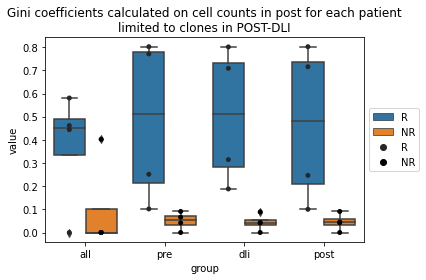

In [318]:
gini_df = pd.DataFrame(index = patients, columns = ['all','pre','dli','post','response'])


for patient in patients:
    if patient in r: 
        response = 'R'
    if patient in nr:
        response = 'NR'
    sub = tcr[tcr['patient']==patient]
    cdr = np.unique(sub['cdr3'])
    DF = clone_df.loc[cdr]
    
    
    r_sign = np.sign(DF[['PRE','POST','DLI']])
    r_sign = r_sign[r_sign['POST']==1]
    
    
    
    shared = r_sign[r_sign.sum(axis = 1)==3]
    all_size = DF.loc[shared.index, 'POST']
    gini_all = gini(all_size)


    just_pre = r_sign[r_sign['DLI']==0]
    pre_size = DF.loc[just_pre.index, 'POST']
    gini_pre = gini(pre_size)

    just_dli = r_sign[r_sign['PRE']==0]
    dli_size = DF.loc[just_dli.index, 'POST']
    gini_dli = gini(dli_size)

    just_post = r_sign[r_sign['DLI']==0]
    just_post = just_post[just_post['PRE']==0]
    post_size = DF.loc[just_post.index, 'POST']
    gini_post = gini(post_size)


    gini_df.loc[patient] = [gini_all, gini_pre, gini_dli, gini_post,response]

gini_df = gini_df.fillna(0)


gini_df_2 = pd.DataFrame(columns = ['patient','value','group','response'])

for patient in gini_df.index:
    p = patient
    response = gini_df.loc[patient,'response']
    
    for group in ['all','pre','dli','post']:
        gini_df_2.loc[len(gini_df_2)] = [p,gini_df.loc[patient, group],group,response]
        
import seaborn as sns


plt.figure()
sns.boxplot(data = gini_df_2, x = 'group',y = 'value',hue = 'response')
sns.stripplot(data = gini_df_2, x = 'group',y = 'value',hue = 'response',color = 'black',jitter= False, dodge = True)
plt.title('Gini coefficients calculated on cell counts in post for each patient\nlimited to clones in POST-DLI')
plt.legend(bbox_to_anchor = (1,0.5),loc = 'center left')
plt.tight_layout()
plt.savefig('gini_postclones_basedonpostcounts.eps')
plt.show()

/home/cyp2111_columbia_edu/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


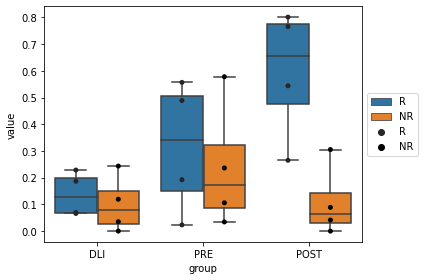

In [341]:
gini_df = pd.DataFrame(index = patients, columns = [
    'POST', 'PRE',
    'DLI','response'])


for patient in patients:
    if patient in r: 
        response = 'R'
    if patient in nr:
        response = 'NR'
    sub = tcr[tcr['patient']==patient]
    cdr = np.unique(sub['cdr3'])
    DF = clone_df.loc[cdr]
    
    
    r_sign = np.sign(DF[['PRE','POST','DLI']])
#     r_sign = r_sign[r_sign['POST']==1]
    
    
#     shared = r_sign[r_sign.sum(axis = 1)!=0]
#     all_size = DF.loc[shared.index, 'Log10CloneSize']
#     gini_all = gini(all_size)
    
    dli_post = r_sign[r_sign['POST']==1]
#     dli_post = dli_post[dli_post['DLI']==1]
#     dli_post = dli_post[dli_post['PRE']==0]

#     print(patient, len(dli_post))
    dli_size = DF.loc[dli_post.index, 'POST']
    gini_all = gini(dli_size)
    
    just_dli = r_sign[r_sign['PRE']==1]
    dli_size = DF.loc[just_dli.index, 'PRE']
    gini_pre = gini(dli_size)
    
    

    just_dli = r_sign[r_sign['DLI']==1]
    dli_size = DF.loc[just_dli.index, 'DLI']
    gini_dli = gini(dli_size)


    gini_df.loc[patient] = [
        gini_all, 
        gini_pre,
        gini_dli,response]

gini_df = gini_df.fillna(0)


gini_df_2 = pd.DataFrame(columns = ['patient','value','group','response'])

for patient in gini_df.index:
    p = patient
    response = gini_df.loc[patient,'response']
    
    for group in ['DLI','PRE','POST']:
        gini_df_2.loc[len(gini_df_2)] = [p,gini_df.loc[patient, group],group,response]
        
import seaborn as sns


plt.figure()
sns.boxplot(data = gini_df_2, x = 'group',y = 'value',hue = 'response')
sns.stripplot(data = gini_df_2, x = 'group',y = 'value',hue = 'response',color = 'black',jitter= False, dodge = True)
# plt.title('Gini coefficients calculated on Log10CloneSize for each patient')
plt.legend(bbox_to_anchor = (1,0.5),loc = 'center left')
plt.tight_layout()
plt.savefig('gini_clones_2.eps')
plt.show()

In [344]:
gini_df_2

,patient,value,group,response
0,EL,0.069742,DLI,R
1,EL,0.023214,PRE,R
2,EL,0.265079,POST,R
3,KC,0.066003,DLI,R
4,KC,0.556653,PRE,R
5,KC,0.801079,POST,R
6,LB,0.186581,DLI,R
7,LB,0.488889,PRE,R
8,LB,0.765606,POST,R
9,MS,0.228557,DLI,R


In [355]:
test1 = gini_df_2[gini_df_2['group']=='POST']
test2 = gini_df_2[gini_df_2['group']=='PRE']

In [356]:
r1 = test1[test1['response']=='R']
nr1 = test2[test2['response']=='R']

from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

mannwhitneyu(r1['value'],nr1['value'])

MannwhitneyuResult(statistic=13.0, pvalue=0.2)

In [357]:
r1

,patient,value,group,response
2,EL,0.265079,POST,R
5,KC,0.801079,POST,R
8,LB,0.765606,POST,R
11,MS,0.543948,POST,R


In [358]:
nr1

,patient,value,group,response
1,EL,0.023214,PRE,R
4,KC,0.556653,PRE,R
7,LB,0.488889,PRE,R
10,MS,0.192394,PRE,R


In [263]:
sample_df = pd.DataFrame(index = patients, columns = np.unique(tcr['time']))

for patient in patients: 
    
    df = tcr[tcr['patient']==patient]
    a,c = np.unique(df['time'], return_counts = True)
    
    for i,t in enumerate(a):
        sample_df.loc[patient, t] = c[i]
        
sample_df


,DLI,POST,PRE
EL,218,143,27
KC,294,1880,81
LB,254,3983,22
MS,868,447,66
AH,1329,51,771
AM,61,NaN,9
GD,NaN,12,58
JS,282,9,15


In [269]:
sample_arr = np.unique(tcr['sample'])
sample_df = pd.DataFrame(index = sample_arr, columns = np.unique(tcr['time']))

for sample in sample_arr: 
    sample = sample
    df = tcr[tcr['sample']==sample]
    a,c = np.unique(df['time'], return_counts = True)
    
    for i,t in enumerate(a):
        sample_df.loc[sample, t] = c[i]
        
sample_df


,DLI,POST,PRE
AH,1329,NaN,NaN
AH1,NaN,NaN,71
AH2,NaN,NaN,699
AH2_,NaN,NaN,1
AH3,NaN,51,NaN
AM,61,NaN,NaN
AM2,NaN,NaN,9
EL,217,NaN,NaN
EL1,NaN,NaN,7
EL2,NaN,115,NaN


In [154]:
lb = tcr[tcr['patient']=='LB']
# np.unique(lb['time'],return_counts = True)
lb_clone = clone_df.loc[np.unique(lb['cdr3'])]
lb_clone[lb_clone['PRE']>0]

,num_unique_patients,Log10CloneSize,PRE,POST,DLI
CAIRDAGGPWETQYF,2,0.954243,1,7,1
CAIREPEQSSYNEQFF,2,0.477121,1,2,0
CASRAWDNTEAFF,2,0.301030,1,1,0
CASRQSGDTQYF,2,0.477121,1,1,1
CASSFGYRETQYF,2,1.146128,1,13,0
CASSLEARSNQPQHF,2,1.380211,1,23,0
CASSLGGANTGELFF,2,0.301030,1,0,1
CASSLGPYGYTF,2,0.301030,1,0,1
CASSLGRNTEAFF,2,0.602060,1,1,2
CASSLGSMNTEAFF,2,0.477121,1,1,1


In [165]:
clone_df

,num_unique_patients,Log10CloneSize,PRE,POST,DLI
CAAVESWDRNTEAFF,1,0.698970,2,0,3
CACGQAYGYTF,1,0.778151,1,0,5
CACRDPGSSYNSPLHF,1,0.301030,0,0,2
CAGGGAEGRAGELFF,1,0.301030,2,0,0
CAGNRDSTFSGANVLTF,1,0.301030,1,0,1
...,...,...,...,...,...
CSVVDQRSGANVLTF,1,0.954243,0,9,0
CSVVDRGRFGEQYF,1,0.301030,0,0,2
CSVVGTGKTYEQYF,1,0.301030,0,2,0
CSVVRTSGNEQFF,2,1.278754,1,18,0


In [229]:
a,c = np.unique(df['patient'])
a[0]

'A'

In [236]:
tcr.loc[index,'sample']

'AM1'

In [219]:
for k in ['LB1_', 'EL1_','GD1_','JS1_']:
    if 'LB' in k: 
        print('yes')

yes


In [221]:
df = tcr[tcr['cdr3']==reassign[0]]
a,c = np.unique(df['patient'],return_counts = True)
max(c/len(df))
a[c == max(c)][0]

'LB'

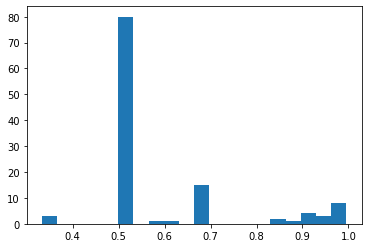

In [203]:
plt.figure()
plt.hist(dup_df['majority_ratio'], bins = 20)
plt.show()

0.425

In [161]:
test = tcr[tcr['cdr3']=='CSVEGGTHYEQYF']
lb = test[test['patient']=='LB']
am = test[test['patient']=='AM']

In [162]:
np.unique(test['sample'], return_counts = True)

(array(['AM1', 'LB1', 'LB2', 'LB4', 'LB6'], dtype=object),
 array([ 12, 309,  87, 155,  30]))

In [163]:
am

,sample,time,response,cluster_number,cdr3,patient,T-subtype,batch,Log10CloneSize
barcode,,,,,,,,,
AACCATGCAAAGGAAG-1-2,AM1,PRE,NONRESPONDER,25,CSVEGGTHYEQYF,AM,TEM/TRM_2,2,2.773786
AACGTTGAGCGATCCC-1-2,AM1,PRE,NONRESPONDER,0,CSVEGGTHYEQYF,AM,TEMRA,2,2.773786
ACAGCCGGTCAGCTAT-1-2,AM1,PRE,NONRESPONDER,0,CSVEGGTHYEQYF,AM,TEMRA,2,2.773786
ATAGACCCATATACCG-1-2,AM1,PRE,NONRESPONDER,0,CSVEGGTHYEQYF,AM,TEMRA,2,2.773786
CACATAGGTACCGTTA-1-2,AM1,PRE,NONRESPONDER,25,CSVEGGTHYEQYF,AM,TEM/TRM_2,2,2.773786
CGCTATCAGATCACGG-1-2,AM1,PRE,NONRESPONDER,0,CSVEGGTHYEQYF,AM,TEMRA,2,2.773786
CTGAAACAGGGTTCCC-1-2,AM1,PRE,NONRESPONDER,5,CSVEGGTHYEQYF,AM,TEM/TRM_1,2,2.773786
GACTACACACAGCGTC-1-2,AM1,PRE,NONRESPONDER,0,CSVEGGTHYEQYF,AM,TEMRA,2,2.773786
GCGAGAATCCAAATGC-1-2,AM1,PRE,NONRESPONDER,25,CSVEGGTHYEQYF,AM,TEM/TRM_2,2,2.773786


/home/cyp2111_columbia_edu/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning:

Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.



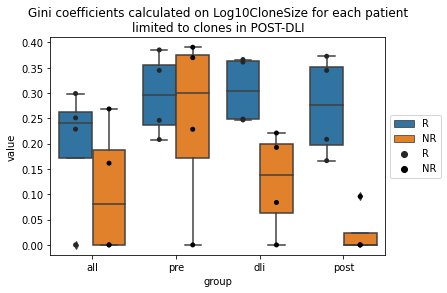

In [119]:
gini_df

,all,pre,dli,post,response
EL,0.228658,0.245969,0.246795,0.166386,R
KC,0.000000,0.344611,0.366066,0.344611,R
LB,0.298939,0.385058,0.360942,0.372517,R
MS,0.250869,0.208110,0.248538,0.208611,R
AH,0.268531,0.228372,0.192555,0.000000,NR
AM,0.161384,0.369738,0.000000,0.000000,NR
GD,0.000000,0.390339,0.083791,0.095687,NR
JS,0.000000,0.000000,0.221008,0.000000,NR


In [102]:
js = tcr[tcr['patient']=='JS']
cdr = np.unique(js['cdr3'])
js = clone_df.loc[cdr]
js = js[js['POST']>0]
js.sum()
# np.unique(js['time'],return_counts = True)

num_unique_patients    14.000000
Log10CloneSize          4.140634
PRE                     0.000000
POST                   17.000000
DLI                    12.000000
dtype: float64

In [37]:
patients = [ 'EL', 'KC', 'LB', 'MS','AH', 'AM', 'GD', 'JS']

for patient in patients:
    sub = tcr[tcr['patient']==patient]
    cdr = np.unique(sub['cdr3'])
    sub_cdr = clone_df.loc[cdr]
    sub_cdr = sub_cdr[sub_cdr['POST']!=0]
    sub_cdr = sub_cdr[sub_cdr['PRE']+sub_cdr['DLI']!=0]


    sub_cdr[['PRE','POST','DLI']] = np.sign(sub_cdr[['PRE','POST','DLI']] )
    ms = sub_cdr[['PRE','POST','DLI']].sum(axis = 1)
    keep = ms.index[ms<3]
    sub_cdr = sub_cdr.loc[keep]
    


    # starting with just dli->post
    source_arr = []
    target_arr = []
    val_arr = []

    for clone in sub_cdr.index:
    #     source_arr.append(1)
    #     target_arr.append(2)

    #     val_arr.append(sub_cdr.loc[clone,'Log10CloneSize'])

    #     else: val_arr.append(0)

        source_arr.append(0)
        target_arr.append(2)

        if sub_cdr.loc[clone,'PRE']!=0 and sub_cdr.loc[clone,'POST']!=0:
            val_arr.append(1)
    #         val_arr.append(sub_cdr.loc[clone,'Log10CloneSize'])
        else: val_arr.append(0)

        source_arr.append(1)
        target_arr.append(2)

        if sub_cdr.loc[clone,'DLI']!=0 and sub_cdr.loc[clone,'POST']!=0:
            val_arr.append(1)
    #         val_arr.append(sub_cdr.loc[clone,'Log10CloneSize'])
        else: val_arr.append(0)

    #     if sub_cdr.loc[clone,'PRE']!=0 and sub_cdr.loc[clone,'POST']!=0:
    #         val_arr.append(sub_cdr.loc[clone,'Log10CloneSize'])

    #     else: val_arr.append(0)




    #     source_arr.append(s)
    #     target_arr.append(t)
    #     label_arr.append('PRE')
    #     label_arr.append('DLI')
    #     color_arr.append('blue')
    #     color_arr.append('red')
    #     s += 2
    #     t += 2

    #     if sub_cdr.loc[clone,'PRE']!=0 and sub_cdr.loc[clone,'DLI']!=0:
    #         val_arr.append(sub_cdr.loc[clone,'Log10CloneSize'])

    #     else: val_arr.append(0)




    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 2,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
    #       label = label_arr,
    #       color = color_arr
          label = ["PRE", "DLI", "POST"],
          color = ["blue",'red','orange']
        ),

        link = dict(
          source = source_arr, # indices correspond to labels, eg A1, A2, A1, B1, ...
          target = target_arr,
          value = val_arr



    #       source = [0, 1], # indices correspond to labels, eg A1, A2, A1, B1, ...
    #       target = [2, 2],
    #       value = [0, 4]
      ))])

    fig.update_layout(title_text=f"Basic Sankey Diagram {patient}, {len(sub_cdr)} clones (excluding clones in all 3 time points)", font_size=10)
    fig.show()

In [34]:
sub_cdr

,num_unique_patients,Log10CloneSize,PRE,POST,DLI
CASAISGRAFEQYF,1,0.778151,0,1,1
CASSDGTGGNEQFF,2,0.778151,0,1,1
CASSDIGKGQQETQYF,1,0.301030,0,1,0
CASSLGPYEQYF,2,0.477121,0,1,1
CASSLGTQNTEAFF,2,0.301030,0,1,1
CASSPGTGNTEAFF,3,0.602060,0,1,1
CASSSGHPNTEAFF,1,0.301030,0,1,0
CASSTRTGVGSPLHF,1,0.301030,0,1,0
CSARAGGPRNEQFF,1,0.301030,0,1,0


In [13]:
r = [ 'EL', 'KC', 'LB', 'MS']
nr = ['AH', 'AM', 'GD', 'JS']
sub = tcr[tcr['patient'].isin(r)]
cdr = np.unique(sub['cdr3'])
sub_cdr = clone_df.loc[cdr]


sign_cdr = pd.DataFrame(index = sub_cdr.index, columns = ['PRE','POST','DLI'] )
# sign_cdr[['PRE','POST','DLI']] = np.sign(sub_cdr[['PRE','POST','DLI']] )
# ms = sign_cdr[['PRE','POST','DLI']].sum(axis = 1)
# keep = ms.index[ms<3]
# sub_cdr = sub_cdr.loc[keep]

sub_cdr_post = sub_cdr[sub_cdr['POST']!=0]
# sub_cdr_post = sub_cdr_post[sub_cdr['PRE']+sub_cdr['DLI']!=0]
sub_cdr_post = sub_cdr_post.sort_values(by = 'POST',ascending = False)



In [16]:
sub_cdr_post[0:40]

,num_unique_patients,Log10CloneSize,PRE,POST,DLI
CSVEGGTHYEQYF,2,2.773786,12,581,0
CASSEPGQGALDTQYF,1,2.649335,0,446,0
CASSLRGQGNYGYTF,1,2.604226,0,401,0
CASSQDYSSNNSPLHF,1,2.552668,0,357,0
CASSLGAGLSRTDTQYF,1,2.447158,0,280,0
CASSLGLDSYNEQFF,1,2.281033,0,191,0
CASTERTSWGEQYF,1,2.164353,0,146,0
CASSLRTGVNEQFF,2,2.158362,1,143,0
CASSLVGGGGVTEAFF,2,2.155336,1,142,0
CASSIDVTSGYEQYF,1,2.152288,0,141,0


In [7]:
plt.figure()
plt.hist(sub_cdr_post['POST'], bins = 100)
plt.show()

NameError: name 'plt' is not defined

In [18]:
# sub_cdr_post = sub_cdr_post[0:200]
n_dli = len(sub_cdr_post[sub_cdr_post['DLI']>0])
n_dli

162

In [23]:
# starting with just dli->post
source_arr = []
target_arr = []
val_arr = []
label_arr = []
color_arr = []
color_link = []
s_dli = 0
s_pre = 2
t_post = 1
sub_cdr = sub_cdr_post
for clone in sub_cdr.index:

    if sub_cdr.loc[clone,'DLI']!=0 and sub_cdr.loc[clone,'POST']!=0:
        val_arr.append(sub_cdr.loc[clone,'Log10CloneSize'])
        source_arr.append(s_dli)
        target_arr.append(t_post)
        label_arr.append('DLI')
        label_arr.append('POST')
        color_arr.append('red')
        color_arr.append('orange')
        s_dli += 2
        t_post+=2
        color_link.append('lightgrey')
#         continue
#     else: 
#         val_arr.append(sub_cdr.loc[clone,'Log10CloneSize'])
#         source_arr.append(s_dli)
#         target_arr.append(t_post)
#         label_arr.append('DLI')
#         label_arr.append('POST')
#         color_arr.append('red')
#         color_arr.append('orange')
#         s_dli += 2
#         t_post+=2
#         color_link.append('white')
#         val_arr.append(0)
        
    

# for clone in sub_cdr.index:
    
    elif sub_cdr.loc[clone,'PRE']!=0 and sub_cdr.loc[clone,'POST']!=0:
        val_arr.append(sub_cdr.loc[clone,'Log10CloneSize'])
        source_arr.append(s_dli)
        target_arr.append(t_post)
        label_arr.append('PRE')
        label_arr.append('POST')
        color_arr.append('blue')
        color_arr.append('orange')
        s_dli += 2
        t_post+=2
        color_link.append('lightgrey')
#         continue
    else: 
        val_arr.append(sub_cdr.loc[clone,'Log10CloneSize'])
        source_arr.append(s_dli)
        target_arr.append(t_post)
        label_arr.append('PRE')
        label_arr.append('POST')
        color_arr.append('white')
        color_arr.append('orange')
        s_dli += 2
        t_post+=2
        color_link.append('white')
#         val_arr.append(0)

        
    
    
    

#     if sub_cdr.loc[clone,'PRE']!=0 and sub_cdr.loc[clone,'DLI']!=0:
#         val_arr.append(sub_cdr.loc[clone,'Log10CloneSize'])
#     else: 
#         val_arr.append(0)
        
#     source_arr.append(s_pre)
#     target_arr.append(t_dli)
#     label_arr.append('PRE')
#     label_arr.append('DLI')
#     color_arr.append('blue')
#     color_arr.append('red')
    
            
    

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 1,
      thickness = 20,
      line = dict(color = "black", width = 0),
#       label = label_arr,
      color = color_arr
#       label = ["Pre", "DLI", "POST"],
#       color = ["blue",'red','orange']
    ),
    
    link = dict(
      source = source_arr, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = target_arr,
#       width = width_arr,
      value = val_arr,
      color = color_link
    
        
        
#       source = [0, 1], # indices correspond to labels, eg A1, A2, A1, B1, ...
#       target = [2, 2],
#       value = [0, 4]
  ))])

fig.update_layout(title_text="Sankey Diagram - R", font_size=10)
# fig.savefig('sankey_r.eps')
# fig.write_image('sankey_r.svg')
fig.show()

In [168]:
len(val_arr)

50

In [82]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 1),
      label = ["A1", "A2", "B1"],
      color = "blue"
      
    ),
    link = dict(
      source = [0, 1, 0], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 1, 3],
      value = [1, 1,1]
      
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()